In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
# lvl1 convolutions are shared between regions
m = 128
k = 256              # lvl1 nodes
n_fft = 4096              # lvl1 receptive field
window = 16384 # total number of audio samples?
stride = 512
batch_size = 500
regions = 1 + (window - n_fft)//stride

In [ ]:
x = np.linspace(0, 2*np.pi, n_fft, endpoint=False)
start_freq1 = 10
end_freq1 = 6000
num_cycles1 = start_freq1*n_fft/44000. # first bin, starting position
scaling_ind1 = np.log2(end_freq1/start_freq1)/k

x = np.linspace(0, 2*np.pi, n_fft, endpoint=False)
start_freq3 = 10
end_freq3 = 6000
num_cycles3 = start_freq3*n_fft/44000. # first bin, starting position
scaling_ind3 = np.log(end_freq3/start_freq3)/k

start_freq2 = 10
end_freq2 = 6000
num_cycles2 = start_freq2*n_fft/44000.
scaling_ind2 = end_freq2/start_freq2/k

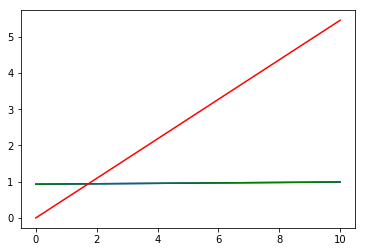

In [405]:
plt.plot(2**(k_list*scaling_ind1)*num_cycles1, 'b')
plt.plot(np.exp(k_list*scaling_ind3)*num_cycles3, 'g')
plt.plot(k_list*scaling_ind2*num_cycles2, 'r')

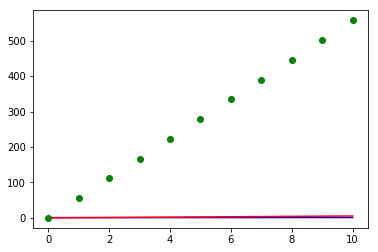

In [406]:
plt.plot(np.exp(k_list*scaling_ind1)*num_cycles1, 'b')
plt.plot(k_list*scaling_ind2*num_cycles2, 'r')
plt.plot(k_list*55.73, 'go')

In [407]:
ind = 1
wsin = np.sin((ind*scaling_ind)*num_cycles*x)
wsin_2 = np.sin(ind*x)

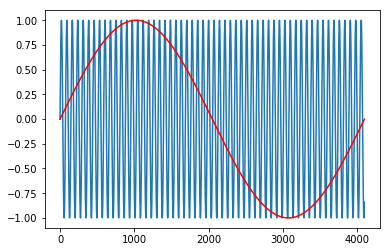

In [408]:
plt.plot(wsin)
plt.plot(wsin_2, 'r')

In [3]:
def create_filters(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = np.arange(0, n_fft, 1)
    wsin = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    wcos = np.empty((freq_bins,1,n_fft), dtype=np.float32)
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = hann(n_fft, sym=False) # same as 0.5-0.5*np.cos(2*np.pi*x/(k))
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*np.sin(2*np.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*np.cos(2*np.pi*k*s/n_fft)
    
    return wsin,wcos

def create_filtersv2(n_fft, freq_bins=None, low=50,high=6000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*torch.sin(2*math.pi*k*s/n_fft)
        wcos[k,0,:] = window_mask*torch.cos(2*math.pi*k*s/n_fft)
    
    return wsin,wcos


In [4]:
import torch
from torch.nn.functional import conv1d, mse_loss
import math
import scipy.io.wavfile as wavfile
wsin, wcos = create_filtersv2(n_fft,k, mode="fft")

In [5]:
_, x = wavfile.read('./piano.wav')

/opt/conda/lib/python3.6/site-packages/scipy/io/wavfile.py:273: WavFileWarning: Chunk (non-data) not understood, skipping it.
  WavFileWarning)


In [6]:
x = x.sum(1)

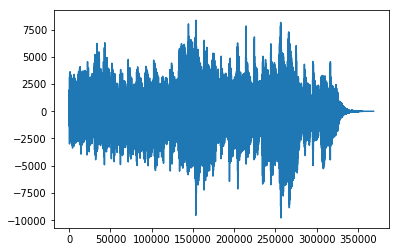

In [7]:
plt.plot(x)

In [8]:
x = torch.tensor(x.reshape(1,-1)).float()

In [9]:
zx = conv1d(x[:,None,:], wsin, stride=stride).pow(2) \
   + conv1d(x[:,None,:], wcos, stride=stride).pow(2)
zx = torch.log(zx + 10e-8)

# Linear Spectrogram

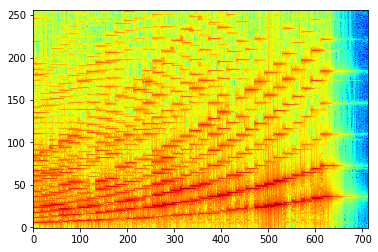

In [10]:
plt.imshow(zx.reshape(-1,713), aspect='auto', origin='lower', cmap='jet')

# Log-f Spectrogram

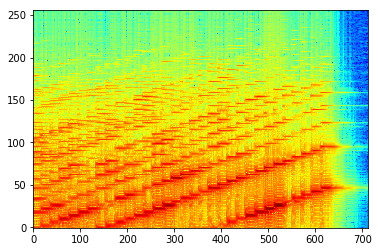

In [15]:
plt.imshow(zx.reshape(-1,713), aspect='auto', origin='lower', cmap='jet')

In [16]:
def create_filtersv2(n_fft, freq_bins=None, low=200,high=8000, mode="fft"):
    if freq_bins==None:
        freq_bins = n_fft//2+1
    
    s = torch.arange(0, n_fft, 1.)
    wsin = torch.empty((freq_bins,1,n_fft))
    wcos = torch.empty((freq_bins,1,n_fft))
    start_freq = low
    end_freq = high
    num_cycles = start_freq*n_fft/44000
    scaling_ind = np.log(end_freq/start_freq)/freq_bins
    # num_cycles = start_freq*d/44000.
    # scaling_ind = np.log(end_freq/start_freq)/k
    
    if mode=="fft":
        window_mask = 1
    elif mode=="stft":
        window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)
    else:
        raise Exception("Unknown mode, please chooes either \"stft\" or \"fft\"")
        

    for k in range(freq_bins): # Only half of the bins contain useful info
        wsin[k,0,:] = window_mask*torch.sin(2*math.pi*np.exp(k*scaling_ind)*num_cycles*s/n_fft)
        wcos[k,0,:] = window_mask*torch.cos(2*math.pi*np.exp(k*scaling_ind)*num_cycles*s/n_fft)
    
    return wsin,wcos


In [20]:
wsin[0].shape

torch.Size([1, 4096])

In [29]:
s = torch.arange(0, n_fft, 1.)
window_mask = 0.5-0.5*torch.cos(2*math.pi*s/(n_fft)) # same as hann(n_fft, sym=False)

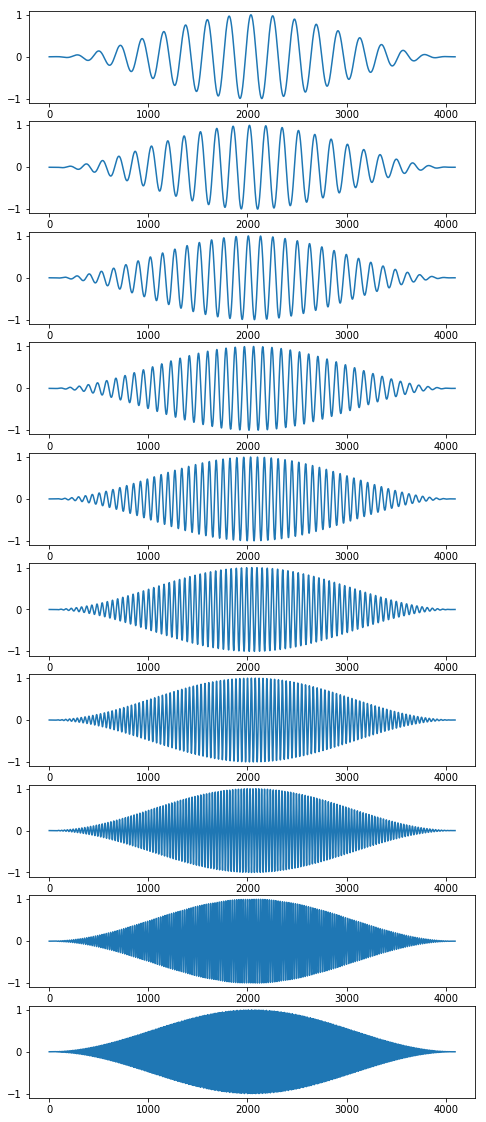

In [32]:
fig, ax = plt.subplots(10,1, figsize=(8,20))
for i in range(10):
    ax[i].plot(window_mask.numpy()*wsin[i*20][0].numpy())

In [13]:
wsin, wcos = create_filtersv2(n_fft,k, mode="fft")
zx = conv1d(x[:,None,:], wsin, stride=stride).pow(2) \
   + conv1d(x[:,None,:], wcos, stride=stride).pow(2)
zx = torch.log(zx + 10e-8)

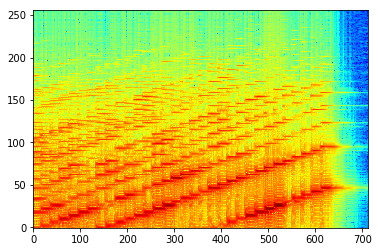

In [14]:
plt.imshow(zx.reshape(-1,713), aspect='auto', origin='lower', cmap='jet')

In [34]:
import librosa

In [46]:
fft_basis, n_fft, _  = librosa.core.constantq.__cqt_filter_fft(44100, 100, n_bins=84,
        bins_per_octave=12, tuning=0.0, filter_scale=1,
        norm=1, sparsity=0.01, window='hann')

In [59]:
fft_basis

<84x4097 sparse matrix of type '<class 'numpy.complex128'>'
	with 14218 stored elements in Compressed Sparse Row format>

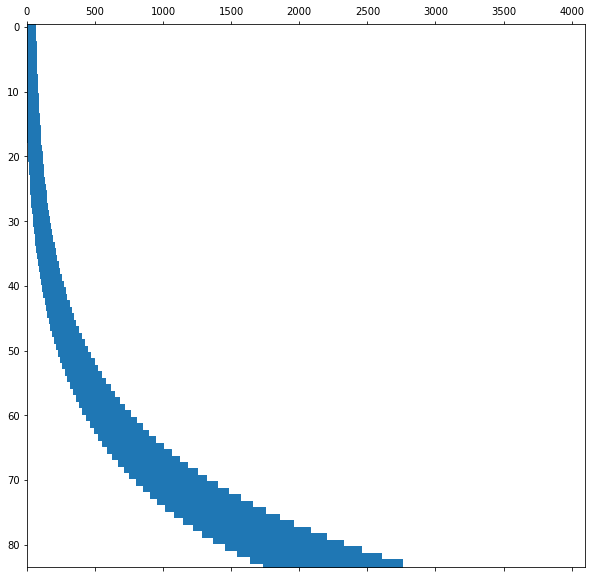

In [71]:
fig, ax = plt.subplots(1,1, figsize=(10,10))
ax.spy(fft_basis, aspect='auto')